In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline

# Regression Analysis: Seasonal Effects with Sklearn Linear Regression
In this notebook, you will build a SKLearn linear regression model to predict Yen futures ("settle") returns with *lagged* Yen futures returns. 

In [2]:
# Futures contract on the Yen-dollar exchange rate:
# This is the continuous chain of the futures contracts that are 1 month to expiration
yen_futures = pd.read_csv(
    Path("yen.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1976-08-02,3398.0,3401.0,3398.0,3401.0,NaN,3401.0,2.0,1.0
1976-08-03,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-04,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-05,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-06,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0


In [3]:
# Trim the dataset to begin on January 1st, 1990
yen_futures = yen_futures.loc["1990-01-01":, :]
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1990-01-02,6954.0,6954.0,6835.0,6847.0,NaN,6847.0,48336.0,51473.0
1990-01-03,6877.0,6910.0,6865.0,6887.0,NaN,6887.0,38206.0,53860.0
1990-01-04,6937.0,7030.0,6924.0,7008.0,NaN,7008.0,49649.0,55699.0
1990-01-05,6952.0,6985.0,6942.0,6950.0,NaN,6950.0,29944.0,53111.0
1990-01-08,6936.0,6972.0,6936.0,6959.0,NaN,6959.0,19763.0,52072.0


# Data Preparation

### Returns

In [4]:
# Create a series using "Settle" price percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
yen_futures["Return"] = (yen_futures[["Settle"]].pct_change() * 100)
yen_futures = yen_futures.replace(-np.inf, np.nan).dropna()
yen_futures.tail()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest,Return
Date,,,,,,,,,
2019-10-09,9381.0,9391.5,9330.5,9343.5,38.5,9338.0,99153.0,145470.0,-0.410601
2019-10-10,9343.5,9380.5,9293.5,9301.0,34.5,9303.5,159397.0,144474.0,-0.369458
2019-10-11,9308.5,9309.0,9240.0,9267.0,52.5,9251.0,158810.0,147471.0,-0.564304
2019-10-14,9259.0,9292.0,9250.5,9261.0,14.0,9265.0,69457.0,153902.0,0.151335
2019-10-15,9264.5,9280.0,9216.5,9220.0,43.5,9221.5,108342.0,151564.0,-0.469509


### Lagged Returns 

In [5]:
# Create a lagged return using the shift function
yen_futures["Lagged Returns"] = yen_futures["Return"].shift()
yen_futures = yen_futures.dropna()
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest,Return,Lagged Returns
Date,,,,,,,,,,
2014-02-19,9768.0,9825.0,9760.0,9773.0,2.0,9773.0,129508.0,197197.0,-0.020460,-0.427829
2014-02-20,9774.0,9837.0,9765.0,9775.0,2.0,9775.0,160202.0,198280.0,0.020465,-0.020460
2014-02-21,9772.0,9776.0,9725.0,9758.0,20.0,9755.0,103091.0,202990.0,-0.204604,0.020465
2014-02-24,9752.0,9789.0,9740.0,9757.0,2.0,9757.0,90654.0,203114.0,0.020502,-0.204604
2014-02-25,9760.0,9808.0,9744.0,9789.0,32.0,9789.0,105498.0,201486.0,0.327970,0.020502


### Train Test Split

In [6]:
# Create a train/test split for the data using 2018-2019 for testing and the rest for training
train = yen_futures[:'2017']
test = yen_futures['2018':]

In [7]:
# Create four dataframes:
# X_train (training set using just the independent variables), X_test (test set of of just the independent variables)
# Y_train (training set using just the "y" variable, i.e., "Futures Return"), Y_test (test set of just the "y" variable):
X_train = train.drop(columns=['Lagged Returns', 'Return'])
X_test = test.drop(columns=['Lagged Returns', 'Return'])
y_train = train['Return']
y_test = test['Return']

In [8]:
X_train.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
2014-02-19,9768.0,9825.0,9760.0,9773.0,2.0,9773.0,129508.0,197197.0
2014-02-20,9774.0,9837.0,9765.0,9775.0,2.0,9775.0,160202.0,198280.0
2014-02-21,9772.0,9776.0,9725.0,9758.0,20.0,9755.0,103091.0,202990.0
2014-02-24,9752.0,9789.0,9740.0,9757.0,2.0,9757.0,90654.0,203114.0
2014-02-25,9760.0,9808.0,9744.0,9789.0,32.0,9789.0,105498.0,201486.0


In [9]:
X_test.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
2018-01-02,8909.5,8957.5,8898.5,8938.0,26.5,8940.5,96714.0,227884.0
2018-01-03,8943.0,8947.5,8913.0,8921.0,21.5,8919.0,93498.0,226582.0
2018-01-04,8917.0,8920.5,8891.0,8901.0,19.0,8900.0,115434.0,224918.0
2018-01-05,8897.0,8902.0,8854.0,8878.0,31.5,8868.5,133023.0,229326.0
2018-01-08,8870.5,8889.0,8849.5,8872.5,5.5,8874.0,81647.0,237100.0


In [10]:
y_train.head()

Date
2014-02-19   -0.020460
2014-02-20    0.020465
2014-02-21   -0.204604
2014-02-24    0.020502
2014-02-25    0.327970
Name: Return, dtype: float64

In [11]:
y_test.head()

Date
2018-01-02    0.297285
2018-01-03   -0.240479
2018-01-04   -0.213028
2018-01-05   -0.353933
2018-01-08    0.062017
Name: Return, dtype: float64

# Linear Regression Model

In [12]:
# Create a Linear Regression model and fit it to the training data
from sklearn.linear_model import LinearRegression

# Fit a SKLearn linear regression using just the training set (X_train, Y_train):
model=LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

# Make predictions using the Testing Data

Note: We want to evaluate the model using data that it has never seen before, in this case: X_test.

In [13]:
# Make a prediction of "y" values using just the test dataset
y_prediction = model.predict(X_test)

In [14]:
# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe:
y_AD = pd.DataFrame({'Actual':y_test, 'Predicted':y_prediction})
y_AD.head()

,Actual,Predicted
Date,,
2018-01-02,0.297285,0.315663
2018-01-03,-0.240479,-0.283832
2018-01-04,-0.213028,-0.201315
2018-01-05,-0.353933,-0.324261
2018-01-08,0.062017,0.024706


<AxesSubplot:xlabel='Date'>

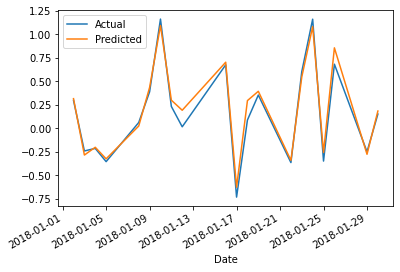

In [15]:
# Plot the first 20 predictions vs the true values
y_AD.head(20).plot()

# Out-of-Sample Performance

Evaluate the model using "out-of-sample" data (X_test and y_test)

In [16]:
from sklearn.metrics import mean_squared_error
# Calculate the mean_squared_error (MSE) on actual versus predicted test "y" 
MSE = mean_squared_error(y_test, y_prediction)

# Using that mean-squared-error, calculate the root-mean-squared error (RMSE):
RMSE = np.sqrt(MSE)

In [17]:
MSE

0.028670527142283426

In [18]:
RMSE

0.1693237347281338

# In-Sample Performance

Evaluate the model using in-sample data (X_train and y_train)

<AxesSubplot:xlabel='Date'>

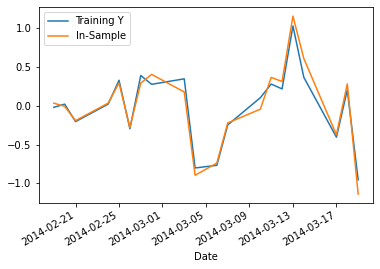

In [19]:
# Construct a dataframe using just the "y" training data:
ISD = pd.DataFrame({'Training Y':y_train})

# Add a column of "in-sample" predictions to that dataframe:  
ISP = model.predict(X_train)
ISD['In-Sample'] = ISP
ISD.head(20).plot()

In [20]:
# Calculate in-sample mean_squared_error (for comparison to out-of-sample)
IS_MSE = mean_squared_error(y_train, ISP)
IS_MSE

0.02631856124795745

In [21]:
# Calculate in-sample root mean_squared_error (for comparison to out-of-sample)
IS_RMSE = np.sqrt(IS_MSE)
IS_RMSE

0.16222996408788806

# Conclusions

## While the two predictions are mathmatically similar to each other, the model performs better on In-Sample Data (ISD). 